# CS 74 Final Project
## Logan Chang, Prof. Vosoughi, 23W

### Step 0: Setup

In [1]:
## IMPORTS
import autograd.numpy as np
from autograd import grad 
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_fscore_support, f1_score, roc_curve, auc, roc_auc_score, accuracy_score, silhouette_score, confusion_matrix
from sklearn.metrics.cluster import rand_score

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import label_binarize

from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn import svm

from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

%matplotlib inline

#### Standard Functions for Classification

In [2]:
## export results from regression prediction to csv
def out_results(y_hat, class_name, num):
    outdf = pd.DataFrame({'id': range(len(y_hat)), 'predicted': y_hat})
    if num != 0:
        outdf.to_csv(f'{class_name}_{num}.csv', index=False)
    else:
        outdf.to_csv(f'{class_name}.csv', index=False)

## construct cutoff labels 
def construct_labels(df_train, cutoff):
    df_train['cutoff'] = [1 if x>cutoff else 0 for x in df_train['overall']]
    return df_train['cutoff']
    
## get classification metrics and aggregate to results dict
def get_metrics(results, y_test, y_pred, num_classes):
    ## accuracy, precision, recall, f1, confusion matrix
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    if num_classes != 5:
        roc_auc = roc_auc_score(y_test, y_pred)
    c_matrix = confusion_matrix(y_test, y_pred)

    ## aggregate metrics to results dict
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1'].append(f1)
    if num_classes != 5:
        results['ROC_AUC'].append(roc_auc)
    results['Confusion Matrix'].append(c_matrix)
    
    return results

## print formatting of average classification metrics for k-fold CV
def cv_metrics(model, num_classes, gaussian=False):  
    
    kf = KFold(n_splits=5)
    ## data transform for gaussian model
    if gaussian:
        X = X_train.toarray()
    else:
        X = X_train
    
    ## instantiate output structs
    results = {'Accuracy' : [], 'Precision' : [], 'Recall' : [], 'F1' : [], 'ROC_AUC': [], 'Confusion Matrix': []}
    matrix = np.zeros((num_classes, num_classes))
    
    ## aggregate metrics across all folds
    for train_index, test_index in kf.split(X, y_train):
        cv_X_train = X[train_index]
        cv_X_test = X[test_index]
        cv_y_train = y_train[train_index]
        cv_y_test = y_train[test_index]

        model.fit(cv_X_train, cv_y_train)
        y_hat = model.predict(cv_X_test).astype(int)
        results = get_metrics(results, cv_y_test, y_hat, num_classes)

    ## average metrics
    f1_avg = sum(results['F1']) / len(results['F1'])
    accuracy_avg = sum(results['Accuracy']) / len(results['Accuracy'])
    precision_avg = sum(results['Precision']) / len(results['Precision'])
    if num_classes != 5:
        roc_auc_avg = sum(results['ROC_AUC']) / len(results['ROC_AUC'])
    for item in results['Confusion Matrix']:
        matrix = np.add(matrix, item)
    matrix_avg = matrix / len(results['Confusion Matrix'])

    ## print results
    print(f"Accuracy Average: {accuracy_avg}")
    print(f"Precision Average: {precision_avg}")
    print(f"F1 Score Average: {f1_avg}")
    if num_classes != 5:
        print(f"ROC AUC Score Average: {roc_auc_avg}")
    print("Confusion Matrix Average:")
    for i in range(num_classes):
        print(str(matrix_avg[i]))
    print("\n")

## Part 1: Binary Classification

### Step 1: Data Processing and Feature Engineering

In [3]:
## read data
df_train = pd.read_csv('Train.csv').fillna('NULL')
df_test = pd.read_csv('Test.csv').fillna('NULL')

In [4]:
## vectorize both text features into TF-IDF matrices

## vectorizer for reviewText
review_vectorizer = TfidfVectorizer(max_features = 1500)
train_review_mat = review_vectorizer.fit_transform(df_train['reviewText'].tolist())
test_review_mat = review_vectorizer.transform(df_test['reviewText'].tolist())

## vectorizer for summary
summary_vectorizer = TfidfVectorizer(max_features = 1500)
train_summary_mat = summary_vectorizer.fit_transform(df_train['summary'].tolist())
test_summary_mat = summary_vectorizer.transform(df_test['summary'].tolist())

## build train, test features
### keep csr format of TF-IDF matrices
X_train = hstack((train_review_mat, train_summary_mat), format='csr')
X_test = hstack((test_review_mat, test_summary_mat), format='csr')

In [5]:
## add verified review to feature matrix
train_verified = df_train['verified'].astype(int).values.reshape(len(df_train['verified']), 1)
test_verified = df_test['verified'].astype(int).values.reshape(len(df_test['verified']), 1)
X_train = hstack((X_train, train_verified), format='csr')
X_test = hstack((X_test, test_verified), format='csr')

In [6]:
print(X_train.shape)
print(X_test.shape)

(29189, 3001)
(4500, 3001)


## Cutoff 1

### Step 2: Data Annotation

In [7]:
## set binary cutoff to 1
y_train = construct_labels(df_train, 1)

### Step 3: Model Selection and Hyperparameter Tuning

#### Model 1: Logisitic Regression

In [8]:
## build model and tuner
logReg = LogisticRegression(max_iter=200, solver='liblinear', random_state=42)
logReg_params = {'penalty':['l1', 'l2'], 'C':[0.01,0.1,1,10], 'class_weight': [None,'balanced'], 'fit_intercept':[True, False]}
logReg_tuner = GridSearchCV(logReg, logReg_params, scoring='f1_macro', cv=5)
## tune model
logReg_tuner.fit(X_train, y_train)
print('Logisitic Regression with optimal hyperparameters had an average macro f1 score of '+str(logReg_tuner.best_score_)+' using the following hyperparameters: '+str(logReg_tuner.best_params_))

Logisitic Regression with optimal hyperparameters had an average macro f1 score of 0.7677168793563615 using the following hyperparameters: {'C': 1, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2'}


In [9]:
## print all hyperparamters combo scores
df_cv_res = pd.DataFrame(logReg_tuner.cv_results_)
df_cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_fit_intercept,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.081772,0.007043,0.004382,0.001005,0.01,None,True,l1,"{'C': 0.01, 'class_weight': None, 'fit_interce...",0.587992,0.525875,0.590147,0.606684,0.594970,0.581133,0.028376,30
1,0.380659,0.600190,0.002845,0.000182,0.01,None,True,l2,"{'C': 0.01, 'class_weight': None, 'fit_interce...",0.587840,0.526970,0.588144,0.607172,0.595595,0.581144,0.027982,29
2,0.059086,0.006212,0.004066,0.000536,0.01,None,False,l1,"{'C': 0.01, 'class_weight': None, 'fit_interce...",0.598415,0.571461,0.592660,0.613658,0.605990,0.596437,0.014351,27
3,0.064297,0.003966,0.002806,0.000336,0.01,None,False,l2,"{'C': 0.01, 'class_weight': None, 'fit_interce...",0.598437,0.544519,0.593506,0.616859,0.607000,0.592064,0.025064,28
4,0.070071,0.011876,0.002825,0.000312,0.01,balanced,True,l1,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",0.481214,0.389174,0.484396,0.487811,0.480011,0.464521,0.037771,32
5,0.085105,0.005821,0.003011,0.000140,0.01,balanced,True,l2,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",0.712049,0.669077,0.755293,0.768021,0.762227,0.733333,0.037688,21
6,0.051912,0.003537,0.003041,0.000188,0.01,balanced,False,l1,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",0.482260,0.389002,0.490726,0.491611,0.480476,0.466815,0.039158,31
7,0.070667,0.003917,0.002914,0.000285,0.01,balanced,False,l2,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",0.729478,0.673569,0.772763,0.786352,0.789676,0.750368,0.043991,17
8,0.116204,0.007194,0.003940,0.000434,0.1,None,True,l1,"{'C': 0.1, 'class_weight': None, 'fit_intercep...",0.689447,0.589260,0.669533,0.702254,0.693914,0.668882,0.041239,26
9,0.121444,0.009304,0.002821,0.000144,0.1,None,True,l2,"{'C': 0.1, 'class_weight': None, 'fit_intercep...",0.710513,0.601182,0.689509,0.722044,0.714928,0.687635,0.044564,24


#### Model 2: Perceptron Classifier

In [10]:
## build model and tuner
perceptron = Perceptron(random_state=42)
perceptron_params = {'penalty':['l1', 'l2', 'elasticnet'], 'alpha':[0.01,0.1,1,10], 'class_weight': [None,'balanced'], 'fit_intercept':[True, False]}
perceptron_tuner = GridSearchCV(perceptron, perceptron_params, scoring='f1_macro', cv=5)
## tune model
perceptron_tuner.fit(X_train, y_train)
print('Perceptron Classifier with optimal hyperparameters had an average macro f1 score of '+str(perceptron_tuner.best_score_)+' using the following hyperparameters: '+str(perceptron_tuner.best_params_))

Perceptron Classifier with optimal hyperparameters had an average macro f1 score of 0.6034076518961486 using the following hyperparameters: {'alpha': 0.01, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'elasticnet'}


In [11]:
## print all hyperparamters combo scores
df_cv_res = pd.DataFrame(perceptron_tuner.cv_results_)
df_cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_fit_intercept,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.051054,0.006289,0.003103,0.000617,0.01,None,True,l1,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.443151,0.443151,0.443205,0.443205,0.443194,0.443181,0.000025,12
1,0.037051,0.007355,0.002581,0.000172,0.01,None,True,l2,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.607224,0.588255,0.599293,0.579904,0.362418,0.547419,0.092969,3
2,0.062961,0.010108,0.002631,0.000144,0.01,None,True,elasticnet,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.443151,0.443151,0.593987,0.607967,0.596051,0.536861,0.076663,7
3,0.046139,0.001654,0.002527,0.000204,0.01,None,False,l1,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.384258,0.518628,0.361101,0.363758,0.470161,0.419581,0.063486,17
4,0.036538,0.003511,0.003176,0.000307,0.01,None,False,l2,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.591184,0.521479,0.515721,0.625128,0.310735,0.512849,0.109248,8
5,0.055296,0.012123,0.002718,0.000123,0.01,None,False,elasticnet,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.614608,0.475460,0.532376,0.474807,0.624470,0.544344,0.064932,4
6,0.055330,0.002395,0.002919,0.000386,0.01,balanced,True,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'f...",0.443151,0.528531,0.443205,0.443205,0.374789,0.446576,0.048794,11
7,0.060056,0.015403,0.002777,0.000181,0.01,balanced,True,l2,"{'alpha': 0.01, 'class_weight': 'balanced', 'f...",0.597255,0.554454,0.486245,0.527649,0.522534,0.537627,0.036895,6
8,0.067927,0.012042,0.002661,0.000268,0.01,balanced,True,elasticnet,"{'alpha': 0.01, 'class_weight': 'balanced', 'f...",0.619350,0.446897,0.393403,0.647231,0.595189,0.540414,0.100994,5
9,0.058657,0.004733,0.002734,0.000304,0.01,balanced,False,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'f...",0.169559,0.299002,0.169441,0.363758,0.375323,0.275417,0.090309,29


#### Model 3: SGD Classifier

In [12]:
## build model and tuner
sgd = SGDClassifier(random_state=42)
sgd_params = {'penalty':['l1', 'l2'], 'alpha':[0.01, 0.1, 1], 'class_weight': [None,'balanced'], 'loss':['hinge', 'modified_huber']}
sgd_tuner = GridSearchCV(sgd, sgd_params, scoring='f1_macro', cv=5)
## tune model
sgd_tuner.fit(X_train, y_train)
print('SGD Classifier with optimal hyperparameters had an average macro f1 score of '+str(sgd_tuner.best_score_)+' using the following hyperparameters: '+str(sgd_tuner.best_params_))

SGD Classifier with optimal hyperparameters had an average macro f1 score of 0.7519699013399526 using the following hyperparameters: {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'modified_huber', 'penalty': 'l2'}


In [13]:
## print all hyperparamters combo scores
df_cv_res = pd.DataFrame(sgd_tuner.cv_results_)
df_cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_loss,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.100236,0.010364,0.002716,0.000515,0.01,None,hinge,l1,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.587323,0.527379,0.589480,0.606684,0.595282,0.581230,0.027751,10
1,0.047571,0.002522,0.002738,0.000149,0.01,None,hinge,l2,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.586502,0.525462,0.588813,0.607009,0.595595,0.580676,0.028512,11
2,0.056481,0.004196,0.002483,0.000115,0.01,None,modified_huber,l1,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.588660,0.528014,0.590147,0.606684,0.595471,0.581795,0.027625,9
3,0.052280,0.004076,0.002655,0.000271,0.01,None,modified_huber,l2,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.641985,0.549243,0.624319,0.658107,0.639720,0.622675,0.038246,6
4,0.049299,0.002305,0.002715,0.000175,0.01,balanced,hinge,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.435456,0.388656,0.421442,0.433249,0.446291,0.425019,0.019820,21
5,0.067127,0.015766,0.002812,0.000384,0.01,balanced,hinge,l2,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.716938,0.661494,0.763723,0.770570,0.778461,0.738237,0.043945,2
6,0.104494,0.021013,0.002845,0.000219,0.01,balanced,modified_huber,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.526395,0.465355,0.651021,0.658153,0.651605,0.590506,0.079680,7
7,0.073796,0.010734,0.002877,0.000526,0.01,balanced,modified_huber,l2,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.709193,0.692253,0.781016,0.786108,0.791280,0.751970,0.042309,1
8,0.060074,0.006882,0.002601,0.000326,0.1,None,hinge,l1,"{'alpha': 0.1, 'class_weight': None, 'loss': '...",0.443151,0.443151,0.443205,0.443205,0.443194,0.443181,0.000025,15
9,0.042667,0.003775,0.002461,0.000157,0.1,None,hinge,l2,"{'alpha': 0.1, 'class_weight': None, 'loss': '...",0.452761,0.451894,0.446721,0.453687,0.450204,0.451054,0.002452,13


In [14]:
## print average k-fold CV metrics for optimally tuned models
cutoff = 1

print(f"5-Fold CV Metrics: Cutoff {cutoff}\n")

print("Tuned Logistic Regression Model:")
logReg.set_params(**logReg_tuner.best_params_)
predictions = cv_metrics(logReg, 2)

print("Tuned Perceptron Model:")
perceptron.set_params(**perceptron_tuner.best_params_)
predictions = cv_metrics(perceptron, 2)

print("Tuned SGD Classifier:")
sgd.set_params(**sgd_tuner.best_params_)
predictions = cv_metrics(sgd, 2)

5-Fold CV Metrics: Cutoff 1

Tuned Logistic Regression Model:
Accuracy Average: 0.7292860696635672
Precision Average: 0.6736275645065177
F1 Score Average: 0.6673847134781905
ROC AUC Score Average: 0.7129709422647212
Confusion Matrix Average:
[775.2 416.2]
[1164.2 3482.2]


Tuned Perceptron Model:
Accuracy Average: 0.6080014658822882
Precision Average: 0.6187957368904804
F1 Score Average: 0.5698461268398727
ROC AUC Score Average: 0.6856480219461065
Confusion Matrix Average:
[950.  241.4]
[2047.  2599.4]


Tuned SGD Classifier:
Accuracy Average: 0.7027691476618749
Precision Average: 0.6565055174503138
F1 Score Average: 0.6468991696186892
ROC AUC Score Average: 0.7136902529532769
Confusion Matrix Average:
[827.8 363.6]
[1371.6 3274.8]




### Step 4: Testing
Since the tuned Logistic Regression seems to have the best average scores, I will use this model to predict the test labels:

In [15]:
## save test predictions
y_test_hat_1 = logReg.predict(X_test)
out_results(y_test_hat_1, "binary", 1)

This model achieved a macro f1 score of 0.79046 on the test set on Kaggle.

## Cutoff 2

### Step 2: Data Annotation

In [16]:
## set binary cutoff to 2
y_train = construct_labels(df_train, 2)

### Step 3: Model Selection and Hyperparameter Tuning

#### Model 1: Logisitic Regression

In [17]:
## build model and tuner
logReg = LogisticRegression(max_iter=200, solver='liblinear', random_state=42)
logReg_params = {'penalty':['l1', 'l2'], 'C':[0.01,0.1,1,10], 'class_weight': [None,'balanced'], 'fit_intercept':[True, False]}
logReg_tuner = GridSearchCV(logReg, logReg_params, scoring='f1_macro', cv=5)
## tune model
logReg_tuner.fit(X_train, y_train)
print('Logisitic Regression with optimal hyperparameters had an average macro f1 score of '+str(logReg_tuner.best_score_)+' using the following hyperparameters: '+str(logReg_tuner.best_params_))

Logisitic Regression with optimal hyperparameters had an average macro f1 score of 0.8196854013287439 using the following hyperparameters: {'C': 1, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2'}


In [18]:
## print all hyperparamters combo scores
df_cv_res = pd.DataFrame(logReg_tuner.cv_results_)
df_cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_fit_intercept,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.071967,0.003559,0.003184,0.000562,0.01,None,True,l1,"{'C': 0.01, 'class_weight': None, 'fit_interce...",0.601520,0.528687,0.584971,0.586637,0.586652,0.577693,0.025229,32
1,0.070457,0.005243,0.002896,0.000248,0.01,None,True,l2,"{'C': 0.01, 'class_weight': None, 'fit_interce...",0.731435,0.649051,0.725773,0.705347,0.727019,0.707725,0.030687,28
2,0.057268,0.003252,0.002783,0.000263,0.01,None,False,l1,"{'C': 0.01, 'class_weight': None, 'fit_interce...",0.648688,0.651623,0.616282,0.610118,0.627772,0.630897,0.016741,30
3,0.073682,0.006416,0.003182,0.000281,0.01,None,False,l2,"{'C': 0.01, 'class_weight': None, 'fit_interce...",0.736377,0.676549,0.726495,0.705095,0.727104,0.714324,0.021494,27
4,0.077053,0.007073,0.003279,0.000377,0.01,balanced,True,l1,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",0.643589,0.566472,0.627175,0.685184,0.619922,0.628468,0.038376,31
5,0.079752,0.010255,0.002973,0.000380,0.01,balanced,True,l2,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",0.784952,0.697811,0.810970,0.804413,0.812895,0.782208,0.043342,24
6,0.059146,0.004424,0.002920,0.000278,0.01,balanced,False,l1,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",0.645728,0.578113,0.627559,0.685130,0.646879,0.636682,0.034775,29
7,0.077356,0.007839,0.002968,0.000324,0.01,balanced,False,l2,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",0.786117,0.717886,0.825911,0.817482,0.828632,0.795206,0.041515,21
8,0.131317,0.010306,0.004075,0.000701,0.1,None,True,l1,"{'C': 0.1, 'class_weight': None, 'fit_intercep...",0.792615,0.723218,0.801146,0.788400,0.806153,0.782306,0.030194,23
9,0.110842,0.007339,0.003013,0.000155,0.1,None,True,l2,"{'C': 0.1, 'class_weight': None, 'fit_intercep...",0.829024,0.741346,0.822489,0.820538,0.838752,0.810430,0.035123,11


#### Model 2: Perceptron Classifier

In [19]:
## build model and tuner
perceptron = Perceptron(random_state=42)
perceptron_params = {'penalty':['l1', 'l2', 'elasticnet'], 'alpha':[0.01,0.1,1,10], 'class_weight': [None,'balanced'], 'fit_intercept':[True, False]}
perceptron_tuner = GridSearchCV(perceptron, perceptron_params, scoring='f1_macro', cv=5)
## tune model
perceptron_tuner.fit(X_train, y_train)
print('Perceptron Classifier with optimal hyperparameters had an average macro f1 score of '+str(perceptron_tuner.best_score_)+' using the following hyperparameters: '+str(perceptron_tuner.best_params_))

Perceptron Classifier with optimal hyperparameters had an average macro f1 score of 0.6375152004092205 using the following hyperparameters: {'alpha': 0.01, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2'}


In [20]:
## print all hyperparamters combo scores
df_cv_res = pd.DataFrame(perceptron_tuner.cv_results_)
df_cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_fit_intercept,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.060363,0.014635,0.002632,0.000248,0.01,None,True,l1,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.458690,0.394467,0.470900,0.289867,0.289903,0.380765,0.078616,17
1,0.043088,0.006369,0.002822,0.000271,0.01,None,True,l2,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.517246,0.539202,0.520275,0.583660,0.340087,0.500094,0.083446,8
2,0.078907,0.019420,0.002842,0.000144,0.01,None,True,elasticnet,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.643590,0.575818,0.632068,0.530684,0.574858,0.591403,0.041426,6
3,0.068245,0.013887,0.002603,0.000230,0.01,None,False,l1,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.558937,0.501286,0.466316,0.289867,0.474605,0.458202,0.090194,10
4,0.037010,0.003577,0.002908,0.000345,0.01,None,False,l2,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.681923,0.568750,0.656447,0.588073,0.613632,0.621765,0.042033,3
5,0.060195,0.006698,0.002741,0.000167,0.01,None,False,elasticnet,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.613422,0.623027,0.441810,0.675532,0.644155,0.599589,0.081717,5
6,0.075216,0.022913,0.002742,0.000471,0.01,balanced,True,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'f...",0.463727,0.394467,0.371785,0.289867,0.444833,0.392936,0.061282,16
7,0.040537,0.008256,0.002639,0.000211,0.01,balanced,True,l2,"{'alpha': 0.01, 'class_weight': 'balanced', 'f...",0.608711,0.626382,0.680312,0.608701,0.601418,0.625105,0.028804,2
8,0.067238,0.012080,0.002725,0.000253,0.01,balanced,True,elasticnet,"{'alpha': 0.01, 'class_weight': 'balanced', 'f...",0.562623,0.516721,0.541699,0.659542,0.595807,0.575278,0.049475,7
9,0.059100,0.005211,0.003104,0.000384,0.01,balanced,False,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'f...",0.575011,0.358107,0.289867,0.466351,0.511681,0.440203,0.103253,12


#### Model 3: SGD Classifier

In [21]:
## build model and tuner
sgd = SGDClassifier(random_state=42)
sgd_params = {'penalty':['l1', 'l2'], 'alpha':[0.01, 0.1, 1], 'class_weight': [None,'balanced'], 'loss':['hinge', 'modified_huber']}
sgd_tuner = GridSearchCV(sgd, sgd_params, scoring='f1_macro', cv=5)
## tune model
sgd_tuner.fit(X_train, y_train)
print('SGD Classifier with optimal hyperparameters had an average macro f1 score of '+str(sgd_tuner.best_score_)+' using the following hyperparameters: '+str(sgd_tuner.best_params_))

SGD Classifier with optimal hyperparameters had an average macro f1 score of 0.8089098035639168 using the following hyperparameters: {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'modified_huber', 'penalty': 'l2'}


In [22]:
## print all hyperparamters combo scores
df_cv_res = pd.DataFrame(sgd_tuner.cv_results_)
df_cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_loss,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.062684,0.007264,0.002614,0.000221,0.01,None,hinge,l1,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.548090,0.500054,0.534194,0.529863,0.530428,0.528526,0.015690,12
1,0.048157,0.004786,0.002684,0.000182,0.01,None,hinge,l2,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.590791,0.504272,0.567645,0.558162,0.564232,0.557020,0.028597,11
2,0.059015,0.008668,0.002552,0.000111,0.01,None,modified_huber,l1,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.629827,0.548766,0.627992,0.616857,0.622636,0.609216,0.030561,7
3,0.054307,0.004688,0.002751,0.000190,0.01,None,modified_huber,l2,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.819043,0.724860,0.816532,0.807346,0.818780,0.797312,0.036476,2
4,0.073343,0.017363,0.002658,0.000128,0.01,balanced,hinge,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.593536,0.533930,0.621412,0.612666,0.613893,0.595087,0.031932,8
5,0.056935,0.003779,0.002560,0.000092,0.01,balanced,hinge,l2,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.709341,0.611654,0.752525,0.772717,0.741990,0.717645,0.056825,4
6,0.070803,0.008756,0.003112,0.000285,0.01,balanced,modified_huber,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.666666,0.593020,0.666032,0.688481,0.660235,0.654887,0.032396,5
7,0.066567,0.007976,0.003064,0.000267,0.01,balanced,modified_huber,l2,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.801565,0.748692,0.832707,0.825582,0.836003,0.808910,0.032429,1
8,0.054301,0.002220,0.002430,0.000150,0.1,None,hinge,l1,"{'alpha': 0.1, 'class_weight': None, 'loss': '...",0.371718,0.371785,0.371785,0.371785,0.371758,0.371766,0.000027,17
9,0.046307,0.003748,0.002686,0.000231,0.1,None,hinge,l2,"{'alpha': 0.1, 'class_weight': None, 'loss': '...",0.381291,0.379479,0.384522,0.383170,0.378159,0.381324,0.002326,14


In [23]:
## print average k-fold CV metrics for optimally tuned models
cutoff = 2

print(f"5-Fold CV Metrics: Cutoff {cutoff}\n")

print("Tuned Logistic Regression Model:")
logReg.set_params(**logReg_tuner.best_params_)
predictions = cv_metrics(logReg, 2)

print("Tuned Perceptron Model:")
perceptron.set_params(**perceptron_tuner.best_params_)
predictions = cv_metrics(perceptron, 2)

print("Tuned SGD Classifier:")
sgd.set_params(**sgd_tuner.best_params_)
predictions = cv_metrics(sgd, 2)

5-Fold CV Metrics: Cutoff 2

Tuned Logistic Regression Model:
Accuracy Average: 0.7278818018543387
Precision Average: 0.7191493301977945
F1 Score Average: 0.717409166940258
ROC AUC Score Average: 0.72778479438654
Confusion Matrix Average:
[1814.6  568.6]
[1020.  2434.6]


Tuned Perceptron Model:
Accuracy Average: 0.6223564832511974
Precision Average: 0.6407491264162853
F1 Score Average: 0.5241438161578353
ROC AUC Score Average: 0.5855012899281438
Confusion Matrix Average:
[ 778.  1605.2]
[ 599.4 2855.2]


Tuned SGD Classifier:
Accuracy Average: 0.7269217299500422
Precision Average: 0.7200863189890578
F1 Score Average: 0.7158564110232619
ROC AUC Score Average: 0.7316296021692464
Confusion Matrix Average:
[1895.2  488. ]
[1106.2 2348.4]




### Step 4: Testing
Again, the tuned Logistic Regression seems to have the best average scores, I will use this model to predict the test labels:

In [24]:
## save test predictions
y_test_hat_2 = logReg.predict(X_test)
out_results(y_test_hat_2, "binary", 2)

This model achieved a macro f1 score of 0.83634 on the test set on Kaggle.

## Cutoff 3

### Step 2: Data Annotation

In [25]:
## set binary cutoff to 3
y_train = construct_labels(df_train, 3)

### Step 3: Model Selection and Hyperparameter Tuning

#### Model 1: Logisitic Regression

In [26]:
## build model and tuner
logReg = LogisticRegression(max_iter=200, solver='liblinear', random_state=42)
logReg_params = {'penalty':['l1', 'l2'], 'C':[0.01,0.1,1,10], 'class_weight': [None,'balanced'], 'fit_intercept':[True, False]}
logReg_tuner = GridSearchCV(logReg, logReg_params, scoring='f1_macro', cv=5)
## tune model
logReg_tuner.fit(X_train, y_train)
print('Logisitic Regression with optimal hyperparameters had an average macro f1 score of '+str(logReg_tuner.best_score_)+' using the following hyperparameters: '+str(logReg_tuner.best_params_))

Logisitic Regression with optimal hyperparameters had an average macro f1 score of 0.8417391261909515 using the following hyperparameters: {'C': 1, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l2'}


In [27]:
## print all hyperparamters combo scores
df_cv_res = pd.DataFrame(logReg_tuner.cv_results_)
df_cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_fit_intercept,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.062113,0.004756,0.003655,0.000517,0.01,None,True,l1,"{'C': 0.01, 'class_weight': None, 'fit_interce...",0.666543,0.578193,0.652785,0.655240,0.670710,0.644694,0.033921,32
1,0.077555,0.002338,0.002863,0.000359,0.01,None,True,l2,"{'C': 0.01, 'class_weight': None, 'fit_interce...",0.701800,0.603753,0.700925,0.707313,0.703285,0.683415,0.039892,30
2,0.061300,0.003734,0.003471,0.000203,0.01,None,False,l1,"{'C': 0.01, 'class_weight': None, 'fit_interce...",0.668533,0.596384,0.657270,0.658517,0.678671,0.651875,0.028803,31
3,0.071949,0.006926,0.003334,0.000586,0.01,None,False,l2,"{'C': 0.01, 'class_weight': None, 'fit_interce...",0.713861,0.641480,0.720014,0.728784,0.724967,0.705821,0.032557,29
4,0.062452,0.002916,0.004109,0.000250,0.01,balanced,True,l1,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",0.735259,0.659845,0.721388,0.725401,0.720301,0.712439,0.026821,28
5,0.077777,0.008833,0.002879,0.000246,0.01,balanced,True,l2,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",0.814462,0.749707,0.836449,0.827464,0.834747,0.812566,0.032370,22
6,0.057279,0.006768,0.003791,0.000133,0.01,balanced,False,l1,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",0.736067,0.665466,0.723365,0.725974,0.725082,0.715191,0.025256,27
7,0.077144,0.005087,0.003075,0.000284,0.01,balanced,False,l2,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",0.815504,0.752410,0.843314,0.831337,0.842596,0.817032,0.033844,21
8,0.130682,0.013912,0.003921,0.000466,0.1,None,True,l1,"{'C': 0.1, 'class_weight': None, 'fit_intercep...",0.795524,0.722473,0.810298,0.813611,0.805726,0.789526,0.034077,26
9,0.105266,0.004149,0.003521,0.000783,0.1,None,True,l2,"{'C': 0.1, 'class_weight': None, 'fit_intercep...",0.814140,0.762610,0.840680,0.840160,0.848055,0.821129,0.031441,16


#### Model 2: Perceptron Classifier

In [28]:
## build model and tuner
perceptron = Perceptron(random_state=42)
perceptron_params = {'penalty':['l1', 'l2', 'elasticnet'], 'alpha':[0.01,0.1,1,10], 'class_weight': [None,'balanced'], 'fit_intercept':[True, False]}
perceptron_tuner = GridSearchCV(perceptron, perceptron_params, scoring='f1_macro', cv=5)
## tune model
perceptron_tuner.fit(X_train, y_train)
print('Perceptron Classifier with optimal hyperparameters had an average macro f1 score of '+str(perceptron_tuner.best_score_)+' using the following hyperparameters: '+str(perceptron_tuner.best_params_))

Perceptron Classifier with optimal hyperparameters had an average macro f1 score of 0.6779819664555472 using the following hyperparameters: {'alpha': 0.01, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'elasticnet'}


In [29]:
## print all hyperparamters combo scores
df_cv_res = pd.DataFrame(perceptron_tuner.cv_results_)
df_cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_fit_intercept,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.052801,0.006407,0.002628,0.000212,0.01,None,True,l1,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.281034,0.281034,0.281034,0.281123,0.378514,0.300548,0.038983,41
1,0.041580,0.007272,0.002863,0.000079,0.01,None,True,l2,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.479613,0.618554,0.663474,0.656330,0.487840,0.581162,0.081049,5
2,0.074975,0.016713,0.002671,0.000276,0.01,None,True,elasticnet,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.596220,0.679336,0.650046,0.526007,0.577223,0.605766,0.054112,4
3,0.073247,0.014540,0.002747,0.000346,0.01,None,False,l1,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.513540,0.527423,0.653020,0.584163,0.463311,0.548292,0.064992,8
4,0.034382,0.002840,0.002763,0.000224,0.01,None,False,l2,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.523768,0.548116,0.505975,0.457923,0.676792,0.542515,0.073354,9
5,0.059259,0.005683,0.003077,0.000410,0.01,None,False,elasticnet,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.694465,0.623058,0.708092,0.724168,0.560393,0.662035,0.061455,2
6,0.049575,0.004030,0.002451,0.000174,0.01,balanced,True,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'f...",0.281034,0.281034,0.281034,0.281123,0.378514,0.300548,0.038983,41
7,0.041684,0.005312,0.002693,0.000158,0.01,balanced,True,l2,"{'alpha': 0.01, 'class_weight': 'balanced', 'f...",0.686762,0.546630,0.367407,0.332931,0.640176,0.514781,0.142200,10
8,0.071435,0.010762,0.002881,0.000451,0.01,balanced,True,elasticnet,"{'alpha': 0.01, 'class_weight': 'balanced', 'f...",0.711351,0.600861,0.577590,0.628688,0.611608,0.626020,0.045770,3
9,0.063822,0.010798,0.002776,0.000572,0.01,balanced,False,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'f...",0.675150,0.520487,0.500688,0.559163,0.600098,0.571117,0.062176,6


#### Model 3: SGD Classifier

In [30]:
## build model and tuner
sgd = SGDClassifier(random_state=42)
sgd_params = {'penalty':['l1', 'l2'], 'alpha':[0.01, 0.1, 1], 'class_weight': [None,'balanced'], 'loss':['hinge', 'modified_huber']}
sgd_tuner = GridSearchCV(sgd, sgd_params, scoring='f1_macro', cv=5)
## tune model
sgd_tuner.fit(X_train, y_train)
print('SGD Classifier with optimal hyperparameters had an average macro f1 score of '+str(sgd_tuner.best_score_)+' using the following hyperparameters: '+str(sgd_tuner.best_params_))

SGD Classifier with optimal hyperparameters had an average macro f1 score of 0.830437932064393 using the following hyperparameters: {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'modified_huber', 'penalty': 'l2'}


In [31]:
## print all hyperparamters combo scores
df_cv_res = pd.DataFrame(sgd_tuner.cv_results_)
df_cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_loss,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.092384,0.015685,0.002739,0.000387,0.01,None,hinge,l1,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.632245,0.553436,0.608511,0.610659,0.619080,0.604786,0.026994,11
1,0.045627,0.002084,0.002695,0.000101,0.01,None,hinge,l2,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.643954,0.556944,0.624272,0.629942,0.634391,0.617901,0.031151,9
2,0.067646,0.005377,0.003033,0.000325,0.01,None,modified_huber,l1,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.691495,0.609414,0.681806,0.685452,0.689103,0.671454,0.031194,7
3,0.054012,0.002713,0.002722,0.000346,0.01,None,modified_huber,l2,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.771420,0.707480,0.802125,0.818488,0.800516,0.780006,0.039305,3
4,0.093222,0.009428,0.002688,0.000158,0.01,balanced,hinge,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.675418,0.593876,0.670467,0.662969,0.689929,0.658532,0.033507,8
5,0.065449,0.012728,0.002681,0.000201,0.01,balanced,hinge,l2,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.740441,0.657882,0.755341,0.769652,0.752796,0.735222,0.039769,4
6,0.077657,0.009763,0.003022,0.000490,0.01,balanced,modified_huber,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.741436,0.675705,0.725794,0.680793,0.728468,0.710439,0.026859,5
7,0.061355,0.008565,0.002557,0.000228,0.01,balanced,modified_huber,l2,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.830805,0.770102,0.855544,0.840245,0.855493,0.830438,0.031606,1
8,0.059757,0.005049,0.002500,0.000241,0.1,None,hinge,l1,"{'alpha': 0.1, 'class_weight': None, 'loss': '...",0.378539,0.378539,0.378539,0.378473,0.378514,0.378521,0.000026,17
9,0.038045,0.003180,0.002793,0.000670,0.1,None,hinge,l2,"{'alpha': 0.1, 'class_weight': None, 'loss': '...",0.385675,0.389846,0.389447,0.387965,0.389891,0.388565,0.001605,15


In [32]:
## print average k-fold CV metrics for optimally tuned models
cutoff = 3

print(f"5-Fold CV Metrics: Cutoff {cutoff}\n")

print("Tuned Logistic Regression Model:")
logReg.set_params(**logReg_tuner.best_params_)
predictions = cv_metrics(logReg, 2)

print("Tuned Perceptron Model:")
perceptron.set_params(**perceptron_tuner.best_params_)
predictions = cv_metrics(perceptron, 2)

print("Tuned SGD Classifier:")
sgd.set_params(**sgd_tuner.best_params_)
predictions = cv_metrics(sgd, 2)

5-Fold CV Metrics: Cutoff 3

Tuned Logistic Regression Model:
Accuracy Average: 0.7843394987135675
Precision Average: 0.7789214178227241
F1 Score Average: 0.7507601271350177
ROC AUC Score Average: 0.7491883051532648
Confusion Matrix Average:
[3171.2  384.4]
[ 874.6 1407.6]


Tuned Perceptron Model:
Accuracy Average: 0.6956741036598754
Precision Average: 0.6926011697787191
F1 Score Average: 0.6633149455227205
ROC AUC Score Average: 0.6696649104989973
Confusion Matrix Average:
[2896.2  659.4]
[1117.2 1165. ]


Tuned SGD Classifier:
Accuracy Average: 0.7834146065755878
Precision Average: 0.7708093956382838
F1 Score Average: 0.7542861838666738
ROC AUC Score Average: 0.7532737712719495
Confusion Matrix Average:
[3087.4  468.2]
[ 796.2 1486. ]




### Step 4: Testing
The tuned SGD Regression seems to have the best average scores (slightly better than the tuned Logistic Regression), I will use this model to predict the test labels:

In [33]:
## save test predictions
y_test_hat_3 = sgd.predict(X_test)
out_results(y_test_hat_3, "binary", 3)

This model achieved a macro f1 score of 0.86970 on the test set on Kaggle.

## Cutoff 4

### Step 2: Data Annotation

In [34]:
## set binary cutoff to 4
y_train = construct_labels(df_train, 4)

### Step 3: Model Selection and Hyperparameter Tuning

#### Model 1: Logisitic Regression

In [35]:
## build model and tuner
logReg = LogisticRegression(max_iter=200, solver='liblinear', random_state=42)
logReg_params = {'penalty':['l1', 'l2'], 'C':[0.01,0.1,1,10], 'class_weight': [None,'balanced'], 'fit_intercept':[True, False]}
logReg_tuner = GridSearchCV(logReg, logReg_params, scoring='f1_macro', cv=5)
## tune model
logReg_tuner.fit(X_train, y_train)
print('Logisitic Regression with optimal hyperparameters had an average macro f1 score of '+str(logReg_tuner.best_score_)+' using the following hyperparameters: '+str(logReg_tuner.best_params_))

Logisitic Regression with optimal hyperparameters had an average macro f1 score of 0.8116139799234577 using the following hyperparameters: {'C': 0.1, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2'}


In [36]:
## print all hyperparamters combo scores
df_cv_res = pd.DataFrame(logReg_tuner.cv_results_)
df_cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_fit_intercept,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.069818,0.006295,0.003921,0.000327,0.01,None,True,l1,"{'C': 0.01, 'class_weight': None, 'fit_interce...",0.691393,0.620713,0.659239,0.664309,0.683607,0.663852,0.024622,32
1,0.078660,0.006576,0.002795,0.000251,0.01,None,True,l2,"{'C': 0.01, 'class_weight': None, 'fit_interce...",0.692737,0.623044,0.660652,0.666703,0.684559,0.665539,0.024218,31
2,0.062631,0.004946,0.003359,0.000160,0.01,None,False,l1,"{'C': 0.01, 'class_weight': None, 'fit_interce...",0.691542,0.622935,0.662098,0.665514,0.687291,0.665876,0.024395,30
3,0.071163,0.006025,0.002876,0.000416,0.01,None,False,l2,"{'C': 0.01, 'class_weight': None, 'fit_interce...",0.696126,0.629097,0.667299,0.672810,0.687861,0.670639,0.023185,29
4,0.084816,0.010311,0.004229,0.000655,0.01,balanced,True,l1,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",0.748664,0.698730,0.735857,0.738759,0.735142,0.731431,0.017049,28
5,0.083945,0.006975,0.003051,0.000273,0.01,balanced,True,l2,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",0.812321,0.766388,0.824713,0.815763,0.801353,0.804107,0.020289,8
6,0.071071,0.005864,0.003412,0.000195,0.01,balanced,False,l1,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",0.748937,0.703665,0.739318,0.751133,0.738710,0.736353,0.017086,27
7,0.079819,0.004423,0.002986,0.000341,0.01,balanced,False,l2,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",0.809736,0.770791,0.822562,0.815472,0.802890,0.804290,0.017959,7
8,0.116096,0.009270,0.003723,0.000378,0.1,None,True,l1,"{'C': 0.1, 'class_weight': None, 'fit_intercep...",0.763612,0.705108,0.756808,0.761819,0.761149,0.749699,0.022407,25
9,0.123630,0.005508,0.002833,0.000191,0.1,None,True,l2,"{'C': 0.1, 'class_weight': None, 'fit_intercep...",0.756854,0.702146,0.753882,0.752932,0.760699,0.745303,0.021747,26


#### Model 2: Perceptron Classifier

In [37]:
## build model
perceptron = Perceptron(random_state=42)
perceptron_params = {'penalty':['l1', 'l2', 'elasticnet'], 'alpha':[0.01,0.1,1,10], 'class_weight': [None,'balanced'], 'fit_intercept':[True, False]}
perceptron_tuner = GridSearchCV(perceptron, perceptron_params, scoring='f1_macro', cv=5)
## fit model
perceptron_tuner.fit(X_train, y_train)
print('Perceptron Classifier with optimal hyperparameters had an average macro f1 score of '+str(perceptron_tuner.best_score_)+' using the following hyperparameters: '+str(perceptron_tuner.best_params_))

Perceptron Classifier with optimal hyperparameters had an average macro f1 score of 0.6638453325874798 using the following hyperparameters: {'alpha': 0.01, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l1'}


In [38]:
## print all hyperparamters combo scores
df_cv_res = pd.DataFrame(perceptron_tuner.cv_results_)
df_cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_fit_intercept,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.051514,0.009536,0.002958,0.000436,0.01,None,True,l1,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.161929,0.161929,0.659045,0.446478,0.684187,0.422714,0.228387,29
1,0.044065,0.010088,0.002887,0.000110,0.01,None,True,l2,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.390907,0.465924,0.353482,0.676705,0.698250,0.517054,0.143947,12
2,0.072693,0.016617,0.002992,0.000272,0.01,None,True,elasticnet,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.691837,0.620503,0.659045,0.664309,0.459505,0.619040,0.082949,4
3,0.054194,0.002420,0.002699,0.000099,0.01,None,False,l1,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.691183,0.620503,0.659045,0.664309,0.684187,0.663845,0.024751,1
4,0.039682,0.006168,0.002971,0.000084,0.01,None,False,l2,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.468615,0.666497,0.352515,0.704783,0.485385,0.535559,0.131366,10
5,0.059388,0.004253,0.002812,0.000249,0.01,None,False,elasticnet,"{'alpha': 0.01, 'class_weight': None, 'fit_int...",0.741041,0.619574,0.718993,0.472695,0.709569,0.652374,0.098926,3
6,0.058831,0.001044,0.003145,0.000492,0.01,balanced,True,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'f...",0.161929,0.161929,0.162050,0.664112,0.684187,0.366842,0.250996,36
7,0.053430,0.012606,0.002924,0.000466,0.01,balanced,True,l2,"{'alpha': 0.01, 'class_weight': 'balanced', 'f...",0.672555,0.624268,0.237771,0.236650,0.329157,0.420080,0.190046,30
8,0.079359,0.016785,0.003227,0.000775,0.01,balanced,True,elasticnet,"{'alpha': 0.01, 'class_weight': 'balanced', 'f...",0.584274,0.688672,0.734781,0.704620,0.562029,0.654875,0.068712,2
9,0.058905,0.005183,0.003042,0.000387,0.01,balanced,False,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'f...",0.478869,0.659278,0.446478,0.664112,0.702969,0.590341,0.105832,6


#### Model 3: SGD Classifier

In [39]:
## build model and tuner
sgd = SGDClassifier(random_state=42)
sgd_params = {'penalty':['l1', 'l2'], 'alpha':[0.01, 0.1, 1], 'class_weight': [None,'balanced'], 'loss':['hinge', 'modified_huber']}
sgd_tuner = GridSearchCV(sgd, sgd_params, scoring='f1_macro', cv=5)
## fit model
sgd_tuner.fit(X_train, y_train)
print('SGD Classifier with optimal hyperparameters had an average macro f1 score of '+str(sgd_tuner.best_score_)+' using the following hyperparameters: '+str(sgd_tuner.best_params_))

SGD Classifier with optimal hyperparameters had an average macro f1 score of 0.8126167718289083 using the following hyperparameters: {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'modified_huber', 'penalty': 'l2'}


In [40]:
## print all hyperparamters combo scores
df_cv_res = pd.DataFrame(sgd_tuner.cv_results_)
df_cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_loss,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.074553,0.021639,0.002823,0.000315,0.01,None,hinge,l1,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.691812,0.620713,0.659434,0.664309,0.683607,0.663975,0.024709,9
1,0.043085,0.002442,0.002510,0.000122,0.01,None,hinge,l2,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.691812,0.621062,0.659434,0.664309,0.683607,0.664045,0.024587,8
2,0.065177,0.007594,0.002694,0.000347,0.01,None,modified_huber,l1,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.695983,0.626865,0.665704,0.677076,0.687396,0.670605,0.024104,7
3,0.051897,0.005027,0.002600,0.000135,0.01,None,modified_huber,l2,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.717189,0.655707,0.699380,0.708596,0.725579,0.701290,0.024403,5
4,0.162608,0.048593,0.002657,0.000419,0.01,balanced,hinge,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.733467,0.654710,0.696558,0.709091,0.705893,0.699944,0.025692,6
5,0.066511,0.011136,0.002911,0.000342,0.01,balanced,hinge,l2,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.778634,0.719639,0.773851,0.783498,0.785944,0.768313,0.024689,3
6,0.170773,0.038500,0.002641,0.000261,0.01,balanced,modified_huber,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.744335,0.722037,0.764628,0.756284,0.754879,0.748433,0.014691,4
7,0.080107,0.015219,0.002740,0.000232,0.01,balanced,modified_huber,l2,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.823528,0.785199,0.836155,0.819343,0.798859,0.812617,0.018217,1
8,0.071986,0.009426,0.002495,0.000173,0.1,None,hinge,l1,"{'alpha': 0.1, 'class_weight': None, 'loss': '...",0.446530,0.446530,0.446478,0.446478,0.446520,0.446507,0.000024,18
9,0.051365,0.008247,0.002713,0.000518,0.1,None,hinge,l2,"{'alpha': 0.1, 'class_weight': None, 'loss': '...",0.449310,0.460289,0.455681,0.449255,0.459373,0.454782,0.004748,15


In [41]:
## print average k-fold CV metrics for optimally tuned models
cutoff = 4

print(f"5-Fold CV Metrics: Cutoff {cutoff}\n")

print("Tuned Logistic Regression Model:")
logReg.set_params(**logReg_tuner.best_params_)
predictions = cv_metrics(logReg, 2)

print("Tuned Perceptron Model:")
perceptron.set_params(**perceptron_tuner.best_params_)
predictions = cv_metrics(perceptron, 2)

print("Tuned SGD Classifier:")
sgd.set_params(**sgd_tuner.best_params_)
predictions = cv_metrics(sgd, 2)

5-Fold CV Metrics: Cutoff 4

Tuned Logistic Regression Model:
Accuracy Average: 0.8644697213667427
Precision Average: 0.7729522060593936
F1 Score Average: 0.7760569343610646
ROC AUC Score Average: 0.7894831831558848
Confusion Matrix Average:
[4270.2  439.2]
[352.  776.4]


Tuned Perceptron Model:
Accuracy Average: 0.8486386621875559
Precision Average: 0.9118543439469056
F1 Score Average: 0.6208495699084164
ROC AUC Score Average: 0.6041334727121703
Confusion Matrix Average:
[4.7054e+03 4.0000e+00]
[879.6 248.8]


Tuned SGD Classifier:
Accuracy Average: 0.8632705162627772
Precision Average: 0.7721938922800688
F1 Score Average: 0.772743996838867
ROC AUC Score Average: 0.7841207659774085
Confusion Matrix Average:
[4282.4  427. ]
[371.2 757.2]




### Step 4: Testing
For the last cutoff, logistic regression outperforms the other two models, so I'll use this model to make predictions on the test set:

In [42]:
## save test predictions
y_test_hat_4 = logReg.predict(X_test)
out_results(y_test_hat_4, "binary", 4)

This model achieved a macro f1 score of 0.82972 on the test set on Kaggle.

## Part 2: Multiclass Classification

### Step 0: Setup

In [43]:
## plot 5 ROC curves and average ROC curve with AUC scores for each
def plot_roc(model, tuner, X, y):
    y = label_binarize(y, classes=[1,2,3,4,5])
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    model_binary = OneVsRestClassifier(tuner)
    if model == 'Gaussian NB':
        model_binary.fit(X_train.toarray(), y_train)
        y_score = model_binary.predict_proba(X_test.toarray())
    else:
        model_binary.fit(X_train, y_train)
        y_score = model_binary.predict_proba(X_test)

## figure creation heavily inspired by: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    plt.figure()
    n=1
    for i in range(5):
        plt.plot(fpr[i], tpr[i], label='ROC Curve of class '+str(n)+' area = {1:0.2f}'
                ''.format(i, roc_auc[i]))
        n+=1
        
    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model}: Extension of Receiver Operating Characteristic to binarized multiclass")
    plt.legend()
    plt.show()

### Step 1: Feature Engineering

I used the same feature vector for multiclass classification as I did for the binary classification tasks.

### Step 2: Data Annotation
The 'overall' column will be the target and is already labeled, thus there is no need for additional data annotation

In [44]:
y_train = df_train['overall']
print(y_train)

0        1
1        1
2        1
3        1
4        1
        ..
29184    5
29185    5
29186    5
29187    5
29188    5
Name: overall, Length: 29189, dtype: int64


### Step 3: Model Selection and Hyperparameter Tuning

#### Model 1: One-vs-Rest Multiclass Classifier (using Logistic Regression and common optimal hyperparameters from the binary classifications)

In [45]:
## build model and tuner
oneVRest = OneVsRestClassifier(LogisticRegression(max_iter=200, C=1, penalty='l2', class_weight='balanced', solver='liblinear', random_state=42))
oneVRest_params = {'n_jobs':[-1, 1, 3], 'estimator__fit_intercept':[True, False]}
oneVRest_tuner = GridSearchCV(oneVRest, oneVRest_params, scoring='f1_macro', cv=5)
## tune model
oneVRest_tuner.fit(X_train, y_train)
print('One-vs-Rest Classifier with optimal hyperparameters had an average macro f1 score of '+str(oneVRest_tuner.best_score_)+' using the following hyperparameters: '+str(oneVRest_tuner.best_params_))

One-vs-Rest Classifier with optimal hyperparameters had an average macro f1 score of 0.5779077133237489 using the following hyperparameters: {'estimator__fit_intercept': True, 'n_jobs': -1}


In [46]:
## print all hyperparamters combo scores
df_cv_res = pd.DataFrame(oneVRest_tuner.cv_results_)
df_cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__fit_intercept,param_n_jobs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.178267,0.647394,0.014265,0.001146,True,-1,"{'estimator__fit_intercept': True, 'n_jobs': -1}",0.576855,0.519773,0.602208,0.593572,0.597132,0.577908,0.030286,1
1,1.132864,0.061139,0.005073,0.000483,True,1,"{'estimator__fit_intercept': True, 'n_jobs': 1}",0.576855,0.519773,0.602208,0.593572,0.597132,0.577908,0.030286,1
2,0.963413,0.559994,0.008284,0.003352,True,3,"{'estimator__fit_intercept': True, 'n_jobs': 3}",0.576855,0.519773,0.602208,0.593572,0.597132,0.577908,0.030286,1
3,1.203158,0.710877,0.014586,0.001957,False,-1,"{'estimator__fit_intercept': False, 'n_jobs': -1}",0.576864,0.518385,0.602148,0.594390,0.594809,0.577319,0.030618,4
4,1.031643,0.041521,0.004697,0.000281,False,1,"{'estimator__fit_intercept': False, 'n_jobs': 1}",0.576864,0.518385,0.602148,0.594390,0.594809,0.577319,0.030618,4
5,0.913867,0.539289,0.013812,0.001165,False,3,"{'estimator__fit_intercept': False, 'n_jobs': 3}",0.576864,0.518385,0.602148,0.594390,0.594809,0.577319,0.030618,4


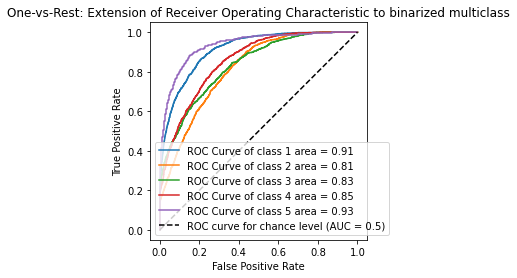

In [47]:
plot_roc('One-vs-Rest', oneVRest_tuner, X_train, y_train)

#### Model 2: Gaussian Naive Bayes

In [48]:
## build model and tuner
gaussianNB = GaussianNB()
gaussianNB_params = {'var_smoothing': np.logspace(0, -9, num = 5)}
gaussianNB_tuner = GridSearchCV(gaussianNB, gaussianNB_params, scoring='f1_macro', cv=5)
## tune model
gaussianNB_tuner.fit(X_train.toarray(), y_train)
print('Guassian Naive Bayes Classifier with optimal hyperparameters had an average macro f1 score of '+str(gaussianNB_tuner.best_score_)+' using the following hyperparameters: '+str(gaussianNB_tuner.best_params_))

Guassian Naive Bayes Classifier with optimal hyperparameters had an average macro f1 score of 0.49747510603136913 using the following hyperparameters: {'var_smoothing': 0.005623413251903491}


In [49]:
## print all hyperparamters combo scores
df_cv_res = pd.DataFrame(gaussianNB_tuner.cv_results_)
df_cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.241206,0.058901,0.813187,0.010896,1,{'var_smoothing': 1.0},0.485558,0.406302,0.455247,0.459355,0.477370,0.456766,0.027601,2
1,1.231365,0.021176,0.819186,0.009588,0.00562341,{'var_smoothing': 0.005623413251903491},0.516672,0.404936,0.522421,0.518884,0.524462,0.497475,0.046348,1
2,1.190778,0.021463,0.832852,0.033716,3.16228e-05,{'var_smoothing': 3.1622776601683795e-05},0.463140,0.378701,0.471990,0.484665,0.467672,0.453233,0.037951,3
3,1.194631,0.019062,0.823637,0.015223,1.77828e-07,{'var_smoothing': 1.7782794100389227e-07},0.420926,0.362878,0.415899,0.432164,0.423174,0.411008,0.024635,4
4,1.203798,0.024219,0.828251,0.010301,1e-09,{'var_smoothing': 1e-09},0.385698,0.327701,0.368210,0.396788,0.393814,0.374442,0.025397,5


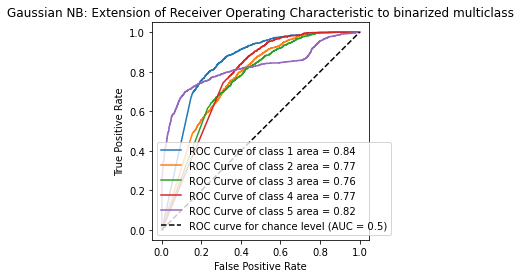

In [50]:
plot_roc('Gaussian NB', gaussianNB_tuner, X_train, y_train)

#### Model 3: Stochastic Gradient Descent

In [51]:
## build model and tuner
sgd_multi = SGDClassifier(random_state=42)
sgd_multi_params = {'penalty':['l1', 'l2'], 'alpha':[0.01, 0.1, 1], 'class_weight': [None,'balanced'], 'loss':['hinge', 'modified_huber']}
sgd_multi_tuner = GridSearchCV(sgd_multi, sgd_multi_params, scoring='f1_macro', cv=5)
## tune model
sgd_multi_tuner.fit(X_train, y_train)
print('SGD Multiclass Classifier with optimal hyperparameters had an average macro f1 score of '+str(sgd_multi_tuner.best_score_)+' using the following hyperparameters: '+str(sgd_multi_tuner.best_params_))

SGD Multiclass Classifier with optimal hyperparameters had an average macro f1 score of 0.5655516961736582 using the following hyperparameters: {'alpha': 0.01, 'class_weight': None, 'loss': 'modified_huber', 'penalty': 'l2'}


In [52]:
## print all hyperparamters combo scores
df_cv_res = pd.DataFrame(sgd_multi_tuner.cv_results_)
df_cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_loss,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.408339,0.066925,0.004250,0.000737,0.01,None,hinge,l1,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.363216,0.280596,0.336655,0.337768,0.351563,0.333960,0.028409,15
1,0.255627,0.004830,0.003960,0.000212,0.01,None,hinge,l2,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.554181,0.469204,0.566214,0.558083,0.564057,0.542348,0.036820,3
2,0.327843,0.011084,0.003779,0.000201,0.01,None,modified_huber,l1,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.453724,0.365099,0.439349,0.450615,0.449041,0.431566,0.033579,9
3,0.279703,0.033363,0.003926,0.000421,0.01,None,modified_huber,l2,"{'alpha': 0.01, 'class_weight': None, 'loss': ...",0.572293,0.503945,0.587871,0.579071,0.584578,0.565552,0.031253,1
4,0.396693,0.060796,0.003838,0.000383,0.01,balanced,hinge,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.365258,0.276239,0.336655,0.337768,0.351563,0.333497,0.030469,16
5,0.256835,0.004034,0.003951,0.000263,0.01,balanced,hinge,l2,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.553294,0.471116,0.565860,0.554681,0.561351,0.541260,0.035366,4
6,0.348885,0.023002,0.004130,0.000498,0.01,balanced,modified_huber,l1,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.453566,0.369883,0.439479,0.446313,0.448359,0.431520,0.031148,10
7,0.277213,0.005128,0.004044,0.000524,0.01,balanced,modified_huber,l2,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.571331,0.502064,0.587942,0.579523,0.585275,0.565227,0.032091,2
8,0.354154,0.041757,0.003543,0.000299,0.1,None,hinge,l1,"{'alpha': 0.1, 'class_weight': None, 'loss': '...",0.112096,0.117756,0.103305,0.101308,0.107609,0.108415,0.005968,19
9,0.231819,0.017830,0.004044,0.000519,0.1,None,hinge,l2,"{'alpha': 0.1, 'class_weight': None, 'loss': '...",0.529887,0.389666,0.536054,0.539359,0.539231,0.506839,0.058688,8


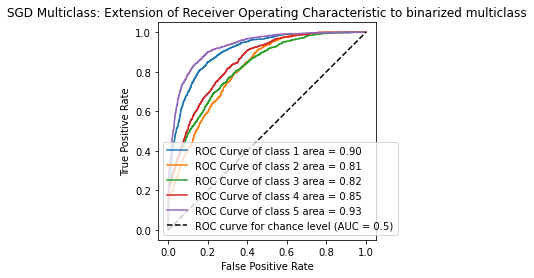

In [53]:
plot_roc('SGD Multiclass', sgd_multi_tuner, X_train, y_train)

In [54]:
## print average k-fold CV metrics for optimally tuned models
print("5-Fold CV Metrics: Multiclass")

print("Tuned One-vs-Rest (Logistic Regression) Model:")
oneVRest = OneVsRestClassifier(LogisticRegression(max_iter=200, C=1, penalty='l2', class_weight='balanced', solver='liblinear', fit_intercept=False, random_state=42))
oneVRest.set_params(**oneVRest_tuner.best_params_)
predictions = cv_metrics(oneVRest, 5)

print("Tuned Gaussian Naive Bayes:")
gaussianNB.set_params(**gaussianNB_tuner.best_params_)
predictions = cv_metrics(gaussianNB, 5, gaussian=True)

print(f"Tuned SGD Classifier:")
sgd_multi.set_params(**sgd_multi_tuner.best_params_)
predictions = cv_metrics(sgd_multi, 5)

5-Fold CV Metrics: Multiclass
Tuned One-vs-Rest (Logistic Regression) Model:
Accuracy Average: 0.4673723396769014
Precision Average: 0.5058313863100972
F1 Score Average: 0.47044019035648893
Confusion Matrix Average:
[690.4 265.2 114.   68.8  53. ]
[390.  408.2 236.2 115.   42.4]
[233.2 218.  485.  183.   53.2]
[192.4 119.6 194.8 461.2 185.8]
[164.2  64.6  62.6 153.4 683.6]


Tuned Gaussian Naive Bayes:
Accuracy Average: 0.4320163693319067
Precision Average: 0.4498658444282869
F1 Score Average: 0.41998327389133044
Confusion Matrix Average:
[644.  124.2 124.4  82.  216.8]
[345.2 291.4 222.6 127.8 204.8]
[202.6 132.8 451.4 173.  212.6]
[167.4  89.  165.8 371.4 360.2]
[132.4  54.2  65.8 112.2 763.8]


Tuned SGD Classifier:
Accuracy Average: 0.4638771823530921
Precision Average: 0.5252168881389154
F1 Score Average: 0.46223585672451667
Confusion Matrix Average:
[768.6 218.2  91.4  57.2  56. ]
[480.  367.8 207.   89.8  47.2]
[279.6 190.6 489.4 150.   62.8]
[226.4 110.2 210.  405.  202.2]
[203

The tuned One-vs-Rest classifier appears to have the best performance, so I will use this to make my test predictions:

In [55]:
## save test predictions
y_test_hat_multi = oneVRest.predict(X_test)
out_results(y_test_hat_multi, "multi", 0)

This model achieved a macro f1 score of 0.59201 on the test set on Kaggle.

## Part 3: Clustering

### Step 1: Data Processing and Feature Engineering

In [56]:
## vectorize reviewText into TF-IDF matrices
review_vectorizer = TfidfVectorizer(min_df=0.2,max_df=0.8,stop_words="english") 
X = review_vectorizer.fit_transform(df_test['reviewText'].tolist())
print(X.shape)

(4500, 2)


### Step 2: Data Annotation
The 'category' column needs to be converted into numerical labels:

In [57]:
## transform categorical column to numerical
categories = df_test['category'].copy()
labels = categories.unique()
labels_idx = list(range(0, len(labels)))
y = np.array(categories.replace(labels, labels_idx)).flatten()

### Part 3: Model Selection and Hyperparameter Tuning

#### Model: K-Mean Clustering
To tune the `n_clusters` hyperparameter, I will construct an elbow graph and choose the optimal value based on the "bend" in the elbow graph.

/Users/logan/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


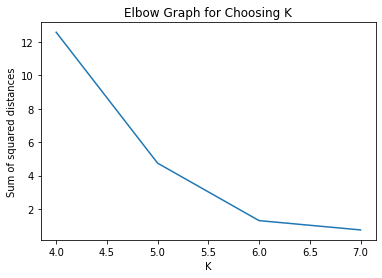

In [58]:
## construct and plot elbow graph
ssd = []
ks = range(4,8)
for num_clusters in ks:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X)
    ssd.append(kmeans.inertia_)
plt.plot(ks, ssd)
plt.xlabel('K') 
plt.ylabel('Sum of squared distances') 
plt.title('Elbow Graph for Choosing K')
plt.show()

From the above graph and the elbow test, `k=6` appears to be the best option for K in the KMeans classifier

In [59]:
## fit and test model
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
print('KMeans Cluster Model with optimal hyperparameters had a silhouette score of '+str(silhouette_score(X, kmeans.labels_))+' and a rand index of '+str(rand_score(y, kmeans.labels_)))

KMeans Cluster Model with optimal hyperparameters had a silhouette score of 0.9882771373157031 and a rand index of 0.5295491837692327
